**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


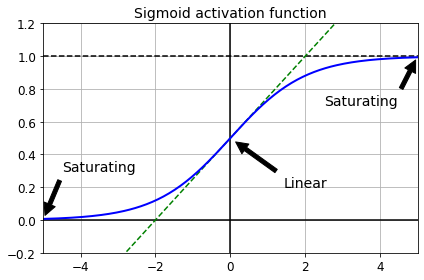

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [6]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [7]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


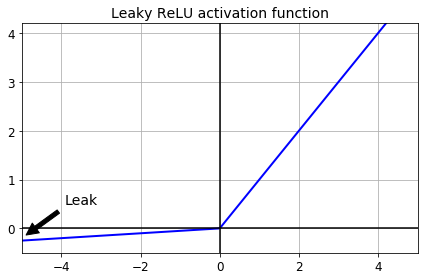

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [10]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [11]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

Now let's try PReLU:

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


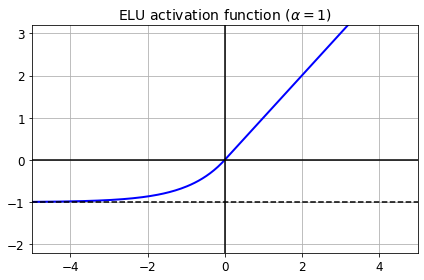

In [20]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [21]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [22]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


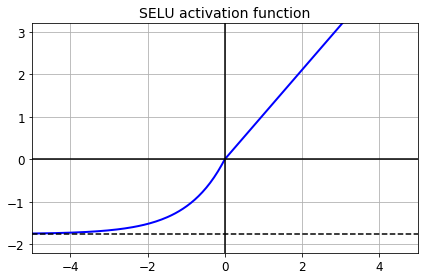

In [24]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [26]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [31]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.7729 - accuracy: 0.3071 - val_loss: 1.3899 - val_accuracy: 0.4524
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.0602 - accuracy: 0.5860 - val_loss: 0.7820 - val_accuracy: 0.7254
Epoch 3/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8437 - accuracy: 0.6949 - val_loss: 0.7487 - val_accuracy: 0.7022
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7273 - accuracy: 0.7344 - val_loss: 0.8475 - val_accuracy: 0.6896
Epoch 5/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7665 - accuracy: 0.7226 - val_loss: 0.6661 - val_accuracy: 0.7730


Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.9751 - accuracy: 0.2315 - val_loss: 1.9868 - val_accuracy: 0.2896
Epoch 2/5
1719/1719 [==============================] - 11s 6ms/step - loss: 1.3886 - accuracy: 0.4257 - val_loss: 1.0659 - val_accuracy: 0.5542
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 1.2192 - accuracy: 0.4824 - val_loss: 1.0226 - val_accuracy: 0.5972
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9435 - accuracy: 0.6122 - val_loss: 0.9141 - val_accuracy: 0.6054
Epoch 5/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8532 - accuracy: 0.6520 - val_loss: 0.7514 - val_accuracy: 0.7030


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [35]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [37]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [38]:
bn1.updates

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [39]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [40]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8661 - accuracy: 0.7120 - val_loss: 0.5674 - val_accuracy: 0.8064
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5733 - accuracy: 0.8015 - val_loss: 0.4864 - val_accuracy: 0.8378
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5143 - accuracy: 0.8223 - val_loss: 0.4479 - val_accuracy: 0.8454
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4763 - accuracy: 0.8349 - val_loss: 0.4259 - val_accuracy: 0.8562
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4517 - accuracy: 0.8429 - val_loss: 0.4105 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4356 - accuracy: 0.8470 - val_loss: 0.3985 - val_accuracy: 0.8654
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4217 - accuracy: 0.8515 - val_loss: 0.3886 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [41]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [43]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0569 - accuracy: 0.6798 - val_loss: 0.6812 - val_accuracy: 0.7876
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6827 - accuracy: 0.7813 - val_loss: 0.5585 - val_accuracy: 0.8230
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5990 - accuracy: 0.8014 - val_loss: 0.5021 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5466 - accuracy: 0.8161 - val_loss: 0.4671 - val_accuracy: 0.8444
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5139 - accuracy: 0.8249 - val_loss: 0.4439 - val_accuracy: 0.8526
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4915 - accuracy: 0.8309 - val_loss: 0.4263 - val_accuracy: 0.8592
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4738 - accuracy: 0.8374 - val_loss: 0.4135 - val_accuracy:

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [44]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [45]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [46]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [50]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [53]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [54]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3523 - accuracy: 0.8787 - val_loss: 0.3289 - val_accuracy: 0.8827
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3170 - accuracy: 0.8894 - val_loss: 0.3012 - val_accuracy: 0.8996
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2893 - val_accuracy: 0.9026
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2835 - accuracy: 0.9021 - val_loss: 0.2773 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2730 - accuracy: 0.9061 - val_loss: 0.2734 - val_accuracy: 0.9073
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2641 - accuracy: 0.9092 - val_loss: 0.2723 - val_accuracy:

In [61]:
model_A.save("my_model_A.h5")

In [55]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [56]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [57]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 17ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [=================

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_215 (Dense)            (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_216 (Dense)            (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

In [62]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [63]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [64]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [65]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 17ms/step - loss: 0.4442 - accuracy: 0.8350 - val_loss: 0.4399 - val_accuracy: 0.8205
Epoch 2/4
7/7 [==============================] - 0s 8ms/step - loss: 0.4124 - accuracy: 0.8550 - val_loss: 0.4112 - val_accuracy: 0.8327
Epoch 3/4
7/7 [==============================] - 0s 8ms/step - loss: 0.3842 - accuracy: 0.8650 - val_loss: 0.3850 - val_accuracy: 0.8479
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.3585 - accuracy: 0.8700 - val_loss: 0.3624 - val_accuracy: 0.8540
Epoch 1/16
7/7 [==============================] - 0s 18ms/step - loss: 0.2927 - accuracy: 0.9250 - val_loss: 0.2480 - val_accuracy: 0.9533
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.2057 - accuracy: 0.9850 - val_loss: 0.1965 - val_accuracy: 0.9787
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.1632 - accuracy: 0.9900 - val_loss: 0.1654 - val_accuracy: 0.9899
Epoch 4/16
7/7 [====================

So, what's the final verdict?

In [66]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [67]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0635 - accuracy: 0.9980


[0.06351099163293839, 0.9980000257492065]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [68]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663

# Faster Optimizers

## Momentum optimization

In [69]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [70]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [71]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [72]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [73]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [74]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [75]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [76]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [77]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [78]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4842 - accuracy: 0.8287 - val_loss: 0.4028 - val_accuracy: 0.8628
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3760 - accuracy: 0.8661 - val_loss: 0.3760 - val_accuracy: 0.8668
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3435 - accuracy: 0.8775 - val_loss: 0.3780 - val_accuracy: 0.8716
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3224 - accuracy: 0.8840 - val_loss: 0.3542 - val_accuracy: 0.8772
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3073 - accuracy: 0.8904 - val_loss: 0.3489 - val_accuracy: 0.8744
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2934 - accuracy: 0.8955 - val_loss: 0.3462 - val_accuracy: 0.8792
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2837 - accuracy: 0.8986 - val_loss: 0.3414 - val_accuracy:

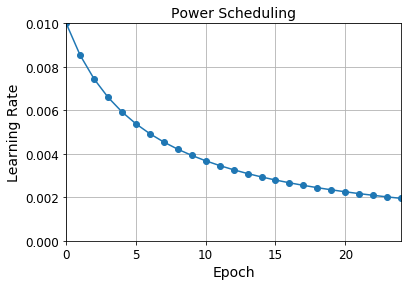

In [79]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [80]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [81]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [93]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [94]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8262 - accuracy: 0.7655 - val_loss: 0.9051 - val_accuracy: 0.7452 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7111 - accuracy: 0.7871 - val_loss: 0.5687 - val_accuracy: 0.8198 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5997 - accuracy: 0.8137 - val_loss: 0.8987 - val_accuracy: 0.7484 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5658 - accuracy: 0.8283 - val_loss: 0.5530 - val_accuracy: 0.8304 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4921 - accuracy: 0.8439 - val_loss: 0.4996 - val_accuracy: 0.8562 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4494 - accuracy: 0.8580 - val_loss: 0.5258 - val_accuracy: 0.8466 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 3s

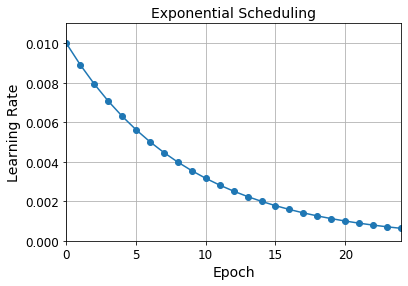

In [95]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [96]:
tf.keras.backend.clear_session()

In [97]:
import tensorflow.keras.backend as K

In [98]:
 K.clear_session()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

## Dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

## Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

In [ ]:
model.evaluate(X_test_scaled, y_test)

In [ ]:
model.evaluate(X_train_scaled, y_train)

In [ ]:
history = model.fit(X_train_scaled, y_train)

## MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

In [ ]:
np.round(y_probas[:, :1], 2)

In [ ]:
np.round(y_proba[:1], 2)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

## Max norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

# Exercises

## 1. to 7.

See appendix A.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [ ]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [ ]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

The model with the lowest validation loss gets about 47% accuracy on the validation set. It took 39 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

* *Is the model converging faster than before?* Much faster! The previous model took 39 epochs to reach the lowest validation loss, while the new model with BN took 18 epochs. That's more than twice as fast as the previous model. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 55% accuracy instead of 47%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged twice as fast, each epoch took about 16s instead of 10s, because of the extra computations required by the BN layers. So overall, although the number of epochs was reduced by 50%, the training time (wall time) was shortened by 30%. Which is still pretty significant!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

In [ ]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

We get 51.4% accuracy, which is better than the original model, but not quite as good as the model using batch normalization. Moreover, it took 13 epochs to reach the best model, which is much faster than both the original model and the BN model, plus each epoch took only 10 seconds, just like the original model. So it's by far the fastest model to train (both in terms of epochs and wall time).

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

The model reaches 50.8% accuracy on the validation set. That's very slightly worse than without dropout (51.4%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

We only get virtually no accuracy improvement in this case (from 50.8% to 50.9%).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

One cycle allowed us to train the model in just 15 epochs, each taking only 3 seconds (thanks to the larger batch size). This is over 3 times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.8% to 52.8%). The batch normalized model reaches a slightly better performance, but it's much slower to train.